# Chapter 8 階層モデル

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 8.1 階層モデルの導入
### 8.1.2 グループ差を考えない場合

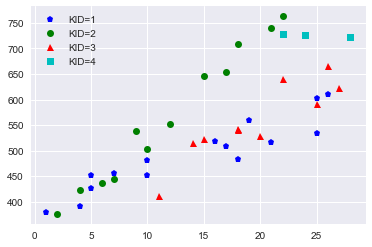

In [2]:
df_1 = pd.read_csv('input/data-salary-2.txt')
syms = ['bp', 'go', 'r^', 'cs', 'mD', 'yv']
for i in range(1,5):
    df = df_1[df_1['KID']==i]
    plt.plot(df['X'], df['Y'], syms[i-1], label='KID='+str(i))
plt.legend(loc='best')
plt.show()

In [3]:
data_1 = df_1.to_dict('list')
data_1['N'] = len(df_1)
data_1['X_new'] = np.linspace(0, 30, 30)
data_1['N_new'] = len(data_1['X_new'])

In [4]:
model_1 = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> s_Y;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a + b*X[n], s_Y);
}

generated quantities {
  real y_new[N_new];
  for (n in 1:N_new)
    y_new[n] = normal_rng(a + b*X_new[n], s_Y);
}
"""

In [5]:
fit_1 = pystan.stan(model_code=model_1, data=data_1, iter=1000, chains=4)
#print(fit_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad9b58397a1eb9222b14ffdfb0f693e1 NOW.


In [6]:
# 信頼区間を書く関数
def plot_pred_range(fit, xs, ys_key, percentiles, alpha):
    ys = (fit.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        xs, \
        [np.percentile(y, percentiles[0]) for y in ys], \
        [np.percentile(y, percentiles[1]) for y in ys], alpha=alpha)

In [7]:
a = np.average(fit_1.extract(permuted=True)['a'])
b = np.average(fit_1.extract(permuted=True)['b'])

50%予測区間と、回帰直線をつけてplot

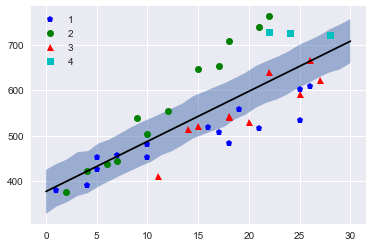

In [8]:
for i in range(1,5):
    d = df_1[df_1['KID']==i]
    plt.plot(d['X'], d['Y'], syms[i-1], label=str(i))
plt.legend(loc='best')
plot_pred_range(fit_1, data_1['X_new'], 'y_new', (25, 75), 0.5)
plt.plot(data_1['X_new'], a+b*data_1['X_new'], 'k-')
plt.show()

### 8.1.3 グループごとに切片と傾きを持つ場合

In [9]:
data_1a = df_1.to_dict('list')
data_1a['N'] = len(df_1)
data_1a['K'] = 4
data_1a['X_new'] = np.linspace(0, 30, 30)
data_1a['N_new'] = len(data_1a['X_new'])

In [10]:
model_1a = """
data {
  int N;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a[K];
  real b[K];
  real<lower=0> s_Y;
}

model {
  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}

generated quantities {
  real y_new[N_new,K];
  for (k in 1:K) {
    for (n in 1:N_new) {
      y_new[n,k] = normal_rng(a[k] + b[k]*X_new[n], s_Y);
    }
  }
}
"""

In [11]:
fit_1a = pystan.stan(model_code=model_1a, data=data_1a, iter=1000, chains=4)
#print(fit_1a)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7473ce4185a3d6c186d043203055b86b NOW.


会社ごとの50%予測区間と、回帰直線をつけてplot

In [12]:
a = [np.average(x) for x in fit_1a.extract(permuted=True)['a'].T]
b = [np.average(x) for x in fit_1a.extract(permuted=True)['b'].T]
clrs = ['b', 'g', 'r', 'c', 'm', 'y']

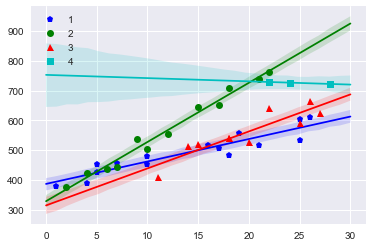

In [13]:
for i in range(1,5):
    d = df_1[df_1['KID']==i]
    plt.plot(d['X'], d['Y'], syms[i-1], label=str(i))
    plt.plot(data_1['X_new'], a[i-1]+b[i-1]*np.array(data_1['X_new']), clrs[i-1]+'-')
    ys = (fit_1a.extract(permuted=True))['y_new'].T[i-1]
    plt.fill_between( \
        data_1['X_new'], \
        [np.percentile(y, 25) for y in ys], \
        [np.percentile(y, 75) for y in ys], facecolor=clrs[i-1], alpha=0.15)
plt.legend(loc='best')
plt.show()

### 8.1.4 階層モデル

In [14]:
data_1b = df_1.to_dict('list')
data_1b['N'] = len(df_1)
data_1b['K'] = 4
data_1b['X_new'] = np.linspace(0, 30, 30)
data_1b['N_new'] = len(data_1a['X_new'])

In [15]:
model_1b = """
data {
  int N;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a0;
  real b0;
  real ak[K];
  real bk[K];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[K];
  real b[K];
  for (k in 1:K) {
    a[k] = a0 + ak[k];
    b[k] = b0 + bk[k];
  }
}

model {
  for (k in 1:K) {
    ak[k] ~ normal(0, s_a);
    bk[k] ~ normal(0, s_b);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}

generated quantities {
  real y_new[N_new,K];
  for (k in 1:K) {
    for (n in 1:N_new) {
      y_new[n,k] = normal_rng(a[k] + b[k]*X_new[n], s_Y);
    }
  }
}
"""

In [16]:
fit_1b = pystan.stan(model_code=model_1b, data=data_1b, iter=1000, chains=4)
#print(fit_1b)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99c9f4a31b6465f1b01b6d98fee3e1a8 NOW.


In [17]:
a = [np.average(x) for x in fit_1b.extract(permuted=True)['a'].T]
b = [np.average(x) for x in fit_1b.extract(permuted=True)['b'].T]

会社ごとの50%予測区間と、回帰直線をつけてplot

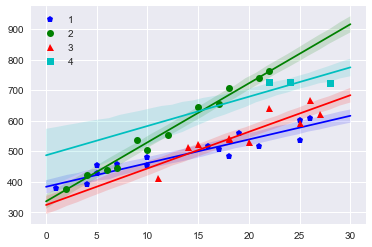

In [18]:
for i in range(1,5):
    d = df_1[df_1['KID']==i]
    plt.plot(d['X'], d['Y'], syms[i-1], label=str(i))
    plt.plot(data_1['X_new'], a[i-1]+b[i-1]*np.array(data_1['X_new']), clrs[i-1]+'-')
    ys = (fit_1b.extract(permuted=True))['y_new'].T[i-1]
    plt.fill_between( \
        data_1['X_new'], \
        [np.percentile(y, 25) for y in ys], \
        [np.percentile(y, 75) for y in ys], facecolor=clrs[i-1], alpha=0.15)
plt.legend(loc='best')
plt.show()

# 8.2 複数の階層を持つ階層モデル

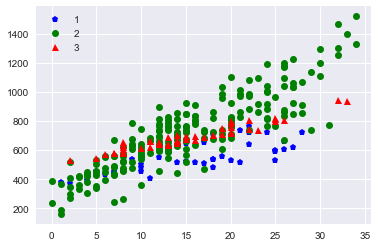

In [19]:
syms = ['bp', 'go', 'r^', 'cs', 'mD', 'yv']
df_2 = pd.read_csv('input/data-salary-3.txt')
for i in range(1,4):
    df = df_2[df_2['GID']==i]
    plt.plot(df['X'], df['Y'], syms[i-1], label=str(i))
plt.legend(loc='best')
plt.show()

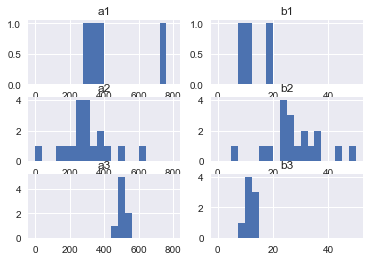

In [20]:
for i in range(1,4):
    df0 = df_2[df_2['GID']==i]
    a_acc = []
    b_acc = []
    for j in range(1, 31):
        df = df0[df0['KID']==j]
        if (len(df)):
            p = np.polyfit(df['X'], df['Y'], 1)
            a_acc.append(p[1])
            b_acc.append(p[0])
    plt.subplot(3, 2, i*2-1)
    plt.hist(a_acc, bins=20, range=(0,800))
    plt.title('a'+str(i))
    plt.subplot(3, 2, i*2)
    plt.hist(b_acc, bins=20, range=(0, 50))
    plt.title('b'+str(i))
plt.show()

In [21]:
data_2 = df_2.to_dict('list')
data_2['N'] = len(df_2)
data_2['G'] = np.max(df_2['GID'])
data_2['K'] = np.max(df_2['KID'])
d = dict()
for kid,gid in zip(df_2['KID'], df_2['GID']):
    d[kid] = gid
data_2['K2G'] = [d[k] for k in sorted(list(d.keys()))] 

### モデル式の想像 --- その(1)

In [22]:
model_2 = """
data {
  int N;
  int G;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
}

parameters {
  real a0;
  real b0;
  real a1[G];
  real b1[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

model {
  for (g in 1:G) {
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(b0, s_bg);
  }

  for (k in 1:K) {
    a[k] ~ normal(a1[K2G[k]], s_a);
    b[k] ~ normal(b1[K2G[k]], s_b);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}
"""

In [23]:
fit_2 = pystan.stan(model_code=model_2, data=data_2, iter=1000, chains=4)
#print(fit_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_080869940618b3b78b4f05770d8f1d37 NOW.


In [24]:
#fit_2.plot(['a0', 'a1', 'b0', 'b1'])

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


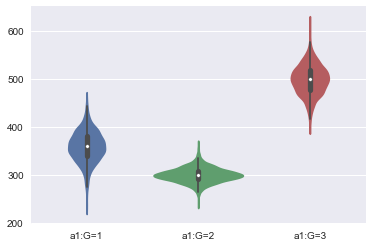

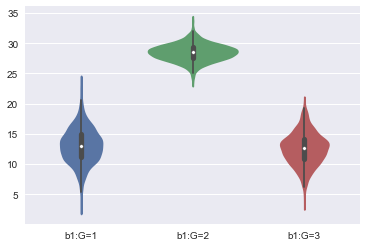

In [25]:
df_2fa = pd.DataFrame(fit_2.extract(permuted=True)['a1'])
df_2fa.columns = ['a1:G=1', 'a1:G=2', 'a1:G=3']
sns.violinplot(df_2fa)
plt.show()
df_2fb = pd.DataFrame(fit_2.extract(permuted=True)['b1'])
df_2fb.columns = ['b1:G=1', 'b1:G=2', 'b1:G=3']
sns.violinplot(df_2fb)
plt.show()

### モデル式の想像 --- その(2)

In [26]:
model_2a = """
data {
  int N;
  int G;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
  int<lower=1, upper=G> GID[N];
}

parameters {
  real a0;
  real b0;
  real a1[G];
  real b1[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a[G];
  real<lower=0> s_b[G];
  real<lower=0> s_Y[G];
}

model {
  for (g in 1:G) {
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(b0, s_bg);
  }

  for (k in 1:K) {
    a[k] ~ normal(a1[K2G[k]], s_a[K2G[k]]);
    b[k] ~ normal(b1[K2G[k]], s_b[K2G[k]]);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y[GID[n]]);
}
"""

In [27]:
fit_2a = pystan.stan(model_code=model_2a, data=data_2, iter=2000, chains=4)
#print(fit_2a)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf8022fc0bb688cb7aee046cab6ea3c9 NOW.


/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


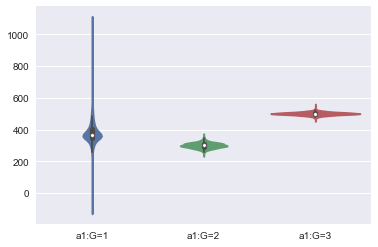

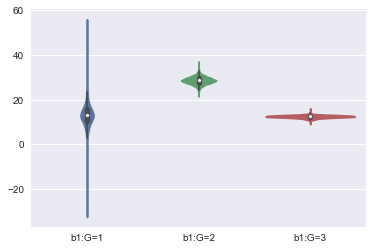

In [28]:
df_2fa = pd.DataFrame(fit_2a.extract(permuted=True)['a1'])
df_2fa.columns = ['a1:G=1', 'a1:G=2', 'a1:G=3']
sns.violinplot(df_2fa)
plt.show()
df_2fb = pd.DataFrame(fit_2a.extract(permuted=True)['b1'])
df_2fb.columns = ['b1:G=1', 'b1:G=2', 'b1:G=3']
sns.violinplot(df_2fb)
plt.show()

## 8.3 非線形モデルの階層モデル

In [29]:
df_3 = pd.read_csv('input/data-conc-2.txt')
df_3

,PersonID,Time1,Time2,Time4,Time8,Time12,Time24
0,1,2.4,5.0,7.5,11.9,12.5,12.7
1,2,1.4,3.9,4.4,7.7,6.4,8.3
2,3,5.2,9.4,19.4,20.2,22.7,24.9
3,4,6.7,12.6,19.1,23.4,25.8,26.1
4,5,0.3,4.7,7.0,10.2,12.9,14.8
5,6,6.3,3.8,11.8,9.2,13.9,18.2
6,7,3.0,4.2,8.8,15.4,10.7,16.2
7,8,6.2,6.8,9.4,11.3,12.4,14.7
8,9,14.4,17.0,22.7,29.8,33.0,32.2
9,10,7.7,10.0,14.8,15.3,18.0,18.7


In [30]:
times = [1,2,4,8,12,24]
cols = ['Time'+str(time) for time in times]
ts = np.linspace(0, 24, 60)
data_3 = {'N':len(df_3), 'T':len(times), 'Time':times, 'T_new':len(ts), 'Time_new':ts}
data_3['Y'] = np.asarray([list(df_3[col]) for col in cols]).T.tolist()

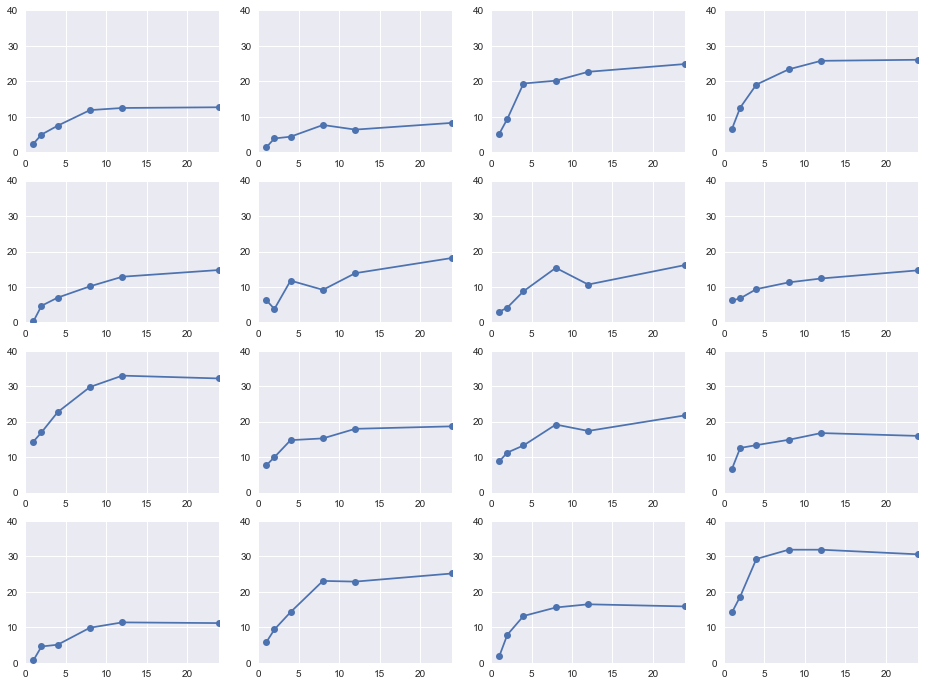

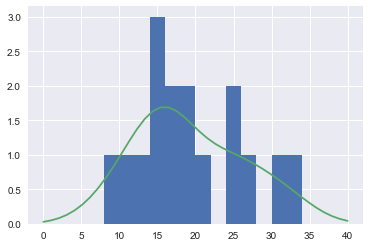

In [31]:
f, axarr = plt.subplots(4, 4, figsize=(16, 12))
for i in range(0, 16):
    axarr[i//4, i%4].plot(times, data_3['Y'][i], 'o-')
    axarr[i//4, i%4].set_xlim((0, 24))
    axarr[i//4, i%4].set_ylim((0, 40))
plt.show()
from scipy import stats
plt.hist(df_3['Time24'], bins=20, range=(0,40))
density = stats.kde.gaussian_kde(df_3['Time24'])
x = np.linspace(0., 40, 40)
plt.plot(x, density(x)*32)
plt.show()

In [32]:
model_3 = """
data {
  int N;
  int T;
  real Time[T];
  real Y[N,T];
  int T_new;
  real Time_new[T_new];
}

parameters {
  real a0;
  real b0;
  real log_a[N];
  real log_b[N];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N];
  real b[N];
  for (n in 1:N) {
    a[n] = exp(log_a[n]);
    b[n] = exp(log_b[n]);
  }
}

model {
  for (n in 1:N) {
    log_a[n] ~ normal(a0, s_a);
    log_b[n] ~ normal(b0, s_b);
  }
  for (n in 1:N)
    for (t in 1:T)
      Y[n,t] ~ normal(a[n]*(1 - exp(-b[n]*Time[t])), s_Y);
}

generated quantities {
  real y_new[N,T_new];
  for (n in 1:N)
    for (t in 1:T_new)
      y_new[n,t] = normal_rng(a[n]*(1 - exp(-b[n]*Time_new[t])), s_Y);
}
"""

In [33]:
fit_3 = pystan.stan(model_code=model_3, data=data_3, iter=1000, chains=4)
#print(fit_3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ffbbbe2f40607added0626b3d49b1a5 NOW.


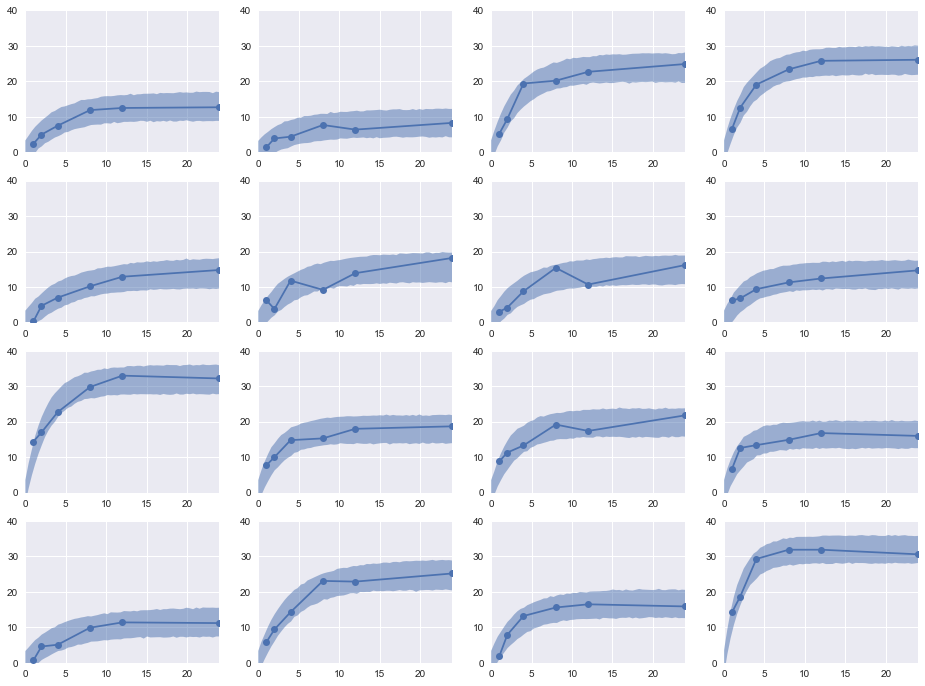

In [34]:
yt = fit_3.extract(permuted=True)['y_new'].transpose(1,2,0)
f, axarr = plt.subplots(4, 4, figsize=(16, 12))
for i in range(0, 16):
    yti = yt[i]
    yli = [np.percentile(y, 2.5) for y in yti]
    yhi = [np.percentile(y, 97.5) for y in yti]
    axarr[i//4, i%4].plot(times, data_3['Y'][i], 'o-')
    axarr[i//4, i%4].fill_between(data_3['Time_new'], yli, yhi, alpha=0.5)
    axarr[i//4, i%4].set_xlim((0, 24))
    axarr[i//4, i%4].set_ylim((0, 40))
plt.show()

## 8.4 ロジスチック回帰の階層モデル

In [35]:
df_4_1 = pd.read_csv('input/data-attendance-4-1.txt')
df_4_2 = pd.read_csv('input/data-attendance-4-2.txt')
print(df_4_1.shape)
df_4_1.head()

(50, 3)


,PersonID,A,Score
0,1,0,69
1,2,1,145
2,3,0,125
3,4,1,86
4,5,1,158


In [36]:
print(df_4_2.shape)
df_4_2.head()

(2396, 4)


,PersonID,CourseID,Weather,Y
0,1,3,B,1
1,1,9,A,1
2,1,1,C,1
3,1,9,A,1
4,1,7,B,1


### 練習問題 (4)

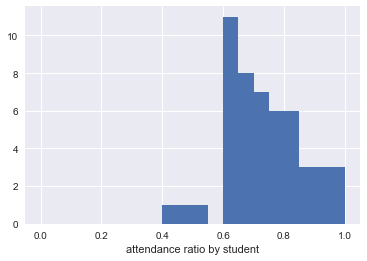

In [37]:
acc = []
for pid in range(1, 51):
    df = df_4_2[df_4_2['PersonID']==pid]
    r = len(df[df['Y']==1])/len(df)
    acc.append(r)
plt.hist(acc, bins=20, range=(0,1))
plt.xlabel('attendance ratio by student')
plt.show()

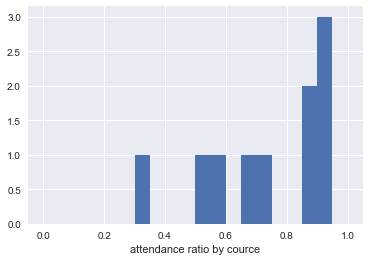

In [38]:
acc = []
for cid in range(1, 11):
    df = df_4_2[df_4_2['CourseID']==cid]
    r = len(df[df['Y']==1])/len(df)
    acc.append(r)
plt.hist(acc, bins=20, range=(0,1))
plt.xlabel('attendance ratio by cource')
plt.show()

In [39]:
data_4_1 = df_4_1.to_dict('list')
data_4_2 = df_4_2.to_dict('list')
conv = {'A':0, 'B':0.2, 'C':1}
data_4 = {'N':len(df_4_1), 'C':10, 'I':len(df_4_2), 'A':data_4_1['A'], \
          'Score':[x/200 for x in data_4_1['Score']], 'PID':data_4_2['PersonID'], \
          'CID':data_4_2['CourseID'], 'W':[conv[w] for w in data_4_2['Weather']], \
          'Y':data_4_2['Y'] }              

In [40]:
model_4 = """
data {
  int N;
  int C;
  int I;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=1, upper=N> PID[I];
  int<lower=1, upper=C> CID[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
  real b_P[N];
  real b_C[C];
  real<lower=0> s_P;
  real<lower=0> s_C;
}

transformed parameters {
  real x_P[N];
  real x_C[C];
  real x_J[I];
  real x[I];
  real q[I];
  for (n in 1:N)
    x_P[n] = b[2]*A[n] + b[3]*Score[n] + b_P[n];
  for (c in 1:C)
    x_C[c] = b_C[c];
  for (i in 1:I) {
    x_J[i] = b[4]*W[i];
    x[i] = b[1] + x_P[PID[i]] + x_C[CID[i]] + x_J[i];
    q[i] = inv_logit(x[i]);
  }
}

model {
  for (n in 1:N)
    b_P[n] ~ normal(0, s_P);
  for (c in 1:C)
    b_C[c] ~ normal(0, s_C);
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

In [41]:
fit_4 = pystan.stan(model_code=model_4, data=data_4, iter=1000, chains=4)
#print(fit_4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da44ed33feae9ca4787e450f0578f69b NOW.


In [42]:
b = fit_4.extract(permuted=True)['b']
df_4f = pd.DataFrame(b)
df_4f[4] = fit_4.extract(permuted=True)['s_P']
df_4f[5] = fit_4.extract(permuted=True)['s_C']
df_4f.columns = ['b1', 'b2', 'b3', 'b4', 'sP', 'sC']
df_4f.head()

,b1,b2,b3,b4,sP,sC
0,0.227702,-0.670249,2.470355,-0.827790,0.464942,1.065474
1,0.319521,-1.037850,3.327787,-0.687461,0.436466,1.822241
2,0.723291,-0.898543,1.300734,-0.502775,0.113315,0.789299
3,0.698867,-0.831302,1.859638,-0.781512,0.353230,1.740090
4,-0.561088,-0.937999,1.957817,-0.700415,0.449091,2.249807


/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


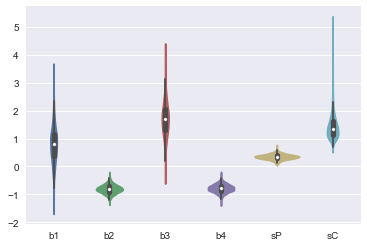

In [43]:
sns.violinplot(data=df_4f)

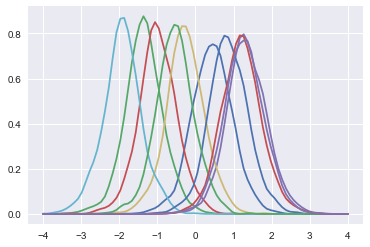

In [44]:
from scipy import stats
bc = fit_4.extract(permuted=True)['b_C'].T
for i in range(0, 10):
    d = stats.kde.gaussian_kde(bc[i])
    x = np.linspace(-4, 4, 80)
    plt.plot(x, d(x))
plt.show()

### 練習問題(5)

無情報事前分布でやってみるとなかなか収束しない。

In [45]:
model_4a = """
data {
  int N;
  int C;
  int I;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=1, upper=N> PID[I];
  int<lower=1, upper=C> CID[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
  real b_P[N];
  real b_C[C];
}

transformed parameters {
  real x_P[N];
  real x_C[C];
  real x_J[I];
  real x[I];
  real q[I];
  for (n in 1:N)
    x_P[n] = b[2]*A[n] + b[3]*Score[n] + b_P[n];
  for (c in 1:C)
    x_C[c] = b_C[c];
  for (i in 1:I) {
    x_J[i] = b[4]*W[i];
    x[i] = b[1] + x_P[PID[i]] + x_C[CID[i]] + x_J[i];
    q[i] = inv_logit(x[i]);
  }
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

In [46]:
fit_4a = pystan.stan(model_code=model_4a, data=data_4, iter=1000, chains=4)
#print(fit_4a)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ca8aaf80787529811224ea954ae48ec7 NOW.


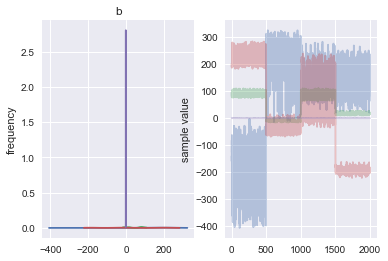

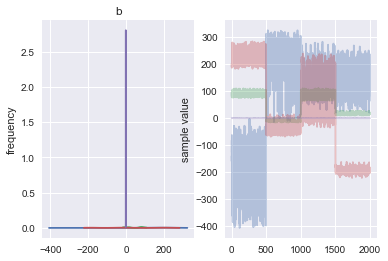

In [47]:
fit_4a.plot(['b'])

## 練習問題(6)

In [48]:
df_6 = pd.read_csv('input/data7a.csv')
print(df_6.shape)
df_6.head()

(100, 2)


,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


(array([ 19.,  15.,  10.,   3.,   6.,   4.,   6.,  37.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 8 Patch objects>)

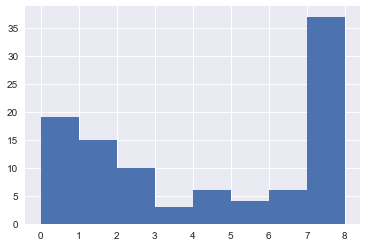

In [49]:
plt.hist(df_6['y'], bins=8, range=(0,8))

In [50]:
data_6 = df_6.to_dict('list')
data_6['N']=len(df_6)

In [51]:
model_6 = """
data {
  int N;
  int<lower=1, upper=N> id[N];
  int<lower=0, upper=8> y[N];
}
parameters {
  real b;
  real b_I[N];
  real<lower=0> s_I;
}
transformed parameters {
  real q[N];
  for (n in 1:N)
    q[n] = inv_logit(b + b_I[n]);
}
model {
  for (n in 1:N)
    b_I[n] ~ normal(0, s_I);
  for (n in 1:N)
    y[n] ~ binomial(8, q[n]);
}
"""

In [52]:
fit_6 = pystan.stan(model_code=model_6, data=data_6, iter=2000, chains=4)
print(fit_6)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e68ad0cf31ce96d305ff626c6a57c672 NOW.


Inference for Stan model: anon_model_e68ad0cf31ce96d305ff626c6a57c672.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b         0.03    0.01   0.34  -0.64  -0.19   0.04   0.26   0.72    772    1.0
b_I[0]   -3.87    0.03   1.83  -8.18  -4.87  -3.59  -2.58  -1.06   4000    1.0
b_I[1]   -1.21    0.01   0.93   -3.2  -1.79  -1.14  -0.56   0.46   4000    1.0
b_I[2]    2.03    0.02   1.15   0.03   1.23   1.92   2.73   4.54   4000    1.0
b_I[3]    3.78    0.03   1.73   1.02   2.55   3.56   4.78   7.83   4000    1.0
b_I[4]   -2.05    0.02   1.08  -4.47  -2.73  -1.97   -1.3  -0.18   4000    1.0
b_I[5]    2.02    0.02   1.11   0.08   1.24   1.94   2.68   4.55   4000    1.0
b_I[6]    3.83    0.03   1.79   1.09   2.53   3.58   4.82   7.97   4000    1.0
b_I[7]    3.81    0.03   1.81   1.03   2.54   3.55   4.79   8.03   4000    1.0
b_I[8]   -2.06    0.0

(array([ 19.,  15.,  10.,   3.,   1.,   5.,   4.,   6.,  17.,  20.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

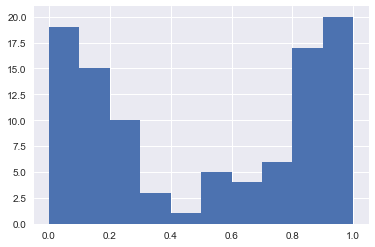

In [53]:
q = fit_6.extract(permuted=True)['q'].T
plt.hist([np.average(x) for x in q], bins=10, range=(0,1))

元のデータの分布をみると単峰性ではないので、正規分布＋ロジット変換が良いのかは、ちょっと疑問を感じる。一方で、それを仮定しない別のモデルを作ると、なかなか収束しない。

## 練習問題(7)

In [54]:
df_7 = pd.read_csv('input/d1.csv')
df_7

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0
5,6,A,C,19
6,7,A,C,4
7,8,A,C,8
8,9,A,C,12
9,10,A,C,8


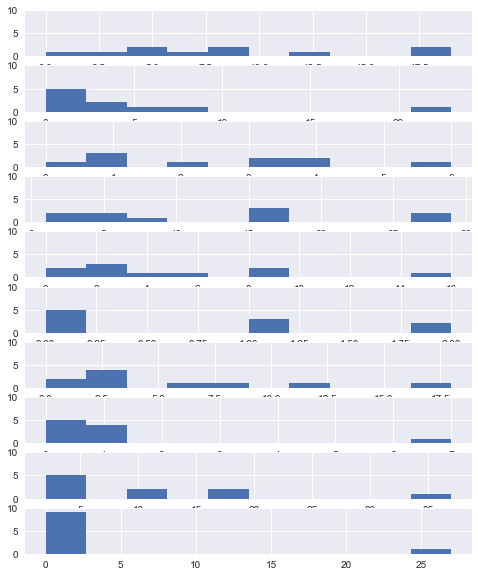

In [55]:
from scipy import stats
plt.figure(figsize=(8, 10))
for (i,c) in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
    plt.subplot(10,1,i+1)
    plt.hist(df_7[df_7['pot']==c]['y'])
    plt.ylim((0,10))
plt.show()

In [56]:
data_7 = {'N':len(df_7), 'N_Pot':10, \
          'N2Pot':[ord(c)-64 for c in df_7['pot']], \
          'F':[(1 if c=='T' else 0) for c in df_7['f']], \
          'Y':list(df_7['y'])}

In [57]:
model_7 = """
data {
  int N;
  int N_Pot;
  int<lower=0, upper=1> F[N];
  int<lower=1, upper=N_Pot> N2Pot[N];
  int Y[N];
}

parameters {
  real b[2];
  real b_I[N];
  real b_Pot[N_Pot];
  real<lower=0> s_I;
  real<lower=0> s_Pot;
}

model {
  for (n in 1:N)
    b_I[n] ~ normal(0, s_I);
  for (p in 1:N_Pot)
    b_Pot[p] ~ normal(0, s_Pot);

  for (n in 1:N)
    Y[n] ~ poisson_log(b[1] + b[2]*F[n] + b_I[n] + b_Pot[N2Pot[n]]);
}
"""

In [58]:
fit_7 = pystan.stan(model_code=model_7, data=data_7, iter=1000, chains=4)
print(fit_7)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc510a85e75b68f9f13910f490d33027 NOW.


Inference for Stan model: anon_model_cc510a85e75b68f9f13910f490d33027.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]       1.36    0.02   0.53   0.28   1.02   1.36   1.71   2.39    506   1.02
b[1]      -0.86    0.03   0.73  -2.25  -1.33  -0.88  -0.41   0.67    536   1.01
b_I[0]    -0.05    0.01   0.49  -1.05  -0.37  -0.02   0.29   0.86   2000    1.0
b_I[1]    -0.61    0.01   0.55   -1.7  -0.97   -0.6  -0.22   0.44   2000    1.0
b_I[2]     1.09    0.01   0.39   0.32   0.83   1.08   1.36   1.84    872    1.0
b_I[3]    -0.21    0.01   0.49  -1.21  -0.54  -0.21   0.13   0.73   2000    1.0
b_I[4]    -1.56    0.02    0.7   -3.1  -1.99   -1.5  -1.06  -0.36   2000    1.0
b_I[5]     1.09    0.01   0.38   0.36   0.83   1.09   1.35   1.85    709   1.01
b_I[6]    -0.39    0.01   0.53  -1.44  -0.74  -0.37  -0.03   0.61   2000    1.0
b_I[7]     0.

In [59]:
s_I = fit_7.extract(permuted=True)['s_I']
s_Pot = fit_7.extract(permuted=True)['s_Pot']
df_7f = pd.DataFrame(np.array([s_I, s_Pot]).T)
df_7f.columns = ['s_I', 's_Pot']

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


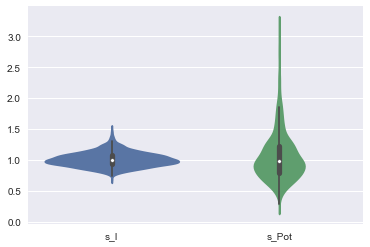

In [60]:
sns.violinplot(df_7f)